<a href="https://colab.research.google.com/github/kirankamatmgm/Fastai-Data-Block-API/blob/master/Datablock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install -q fastai2

Depending on type of problem, blocks in datablock changes and rest are same. Lets see example first,

In [12]:
from fastai2.vision.all import *

## Example 1

In [13]:
path = untar_data(URLs.CAMVID_TINY)

In [14]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes = np.loadtxt(path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    item_tfms = Resize(224),
    batch_tfms=aug_transforms())

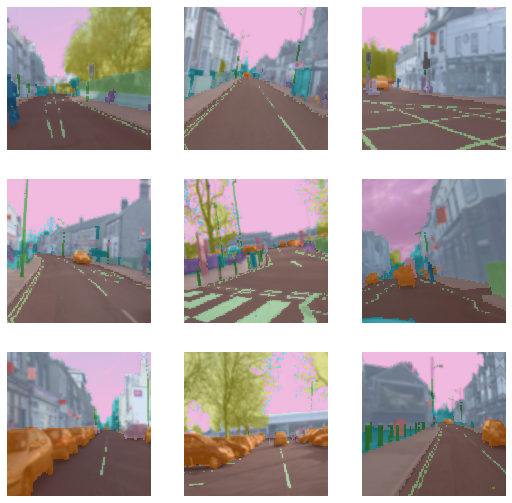

In [15]:
dls = camvid.dataloaders(path/"images")
dls.show_batch()

what did do different from above example which is different from part1 blog, 
just the `MaskBlock` in blocks, so thats how simple creating datablock is.

Depending on tasks blocks = () change. Block's are used to help nest transforms inside of pre-defined problem domain.

So there are different types of blocks.

*   ImageBlock is used if the dataset is of images
*   CategoryBlock is for single-label categorical targets
*   MultiCategoryBlock is for multi-label categorical targets
*   RegressionBlock is for float targets
*   MaskBlock for segmentation masks, potentially with codes
*   PointBlock is for points in an image
*   BBoxBlock is for bounding boxes in an image
*   BBoxLblBlock is for labeled bounding boxes, potentially with vocab

So depending on type of domain these blocks can be used.




So coming to our example The MaskBlock is generated with the codes that give the correpondence between pixel value of the masks and the object they correspond to.

## Example 2

Now lets take multi label classification problem

In [16]:
path2 = untar_data(URLs.PASCAL_2007)

In [17]:
df = pd.read_csv(path2/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [18]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter('is_valid'),
                   get_x=ColReader('fname', pref=str(path2/'train') + os.path.sep),
                   get_y=ColReader('labels', label_delim=' '),
                   item_tfms = [FlipItem(p=0.5),Resize(224,method='pad')],
                   batch_tfms=[*aug_transforms(do_flip=True, flip_vert=True, max_rotate=180.0, max_lighting=0.6,max_warp=0.1, p_affine=0.75, p_lighting=0.75,xtra_tfms=[RandomErasing(p=1.0,sh=0.1, min_aspect=0.2,max_count=2)]),Normalize])

In [19]:
dls2 = pascal.dataloaders(df)

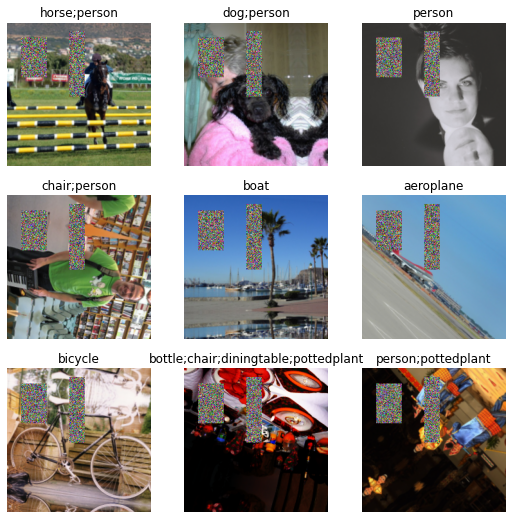

In [20]:
dls2.show_batch()

Basic principles remain same, depending on domain blocks are used.

Now if we see splitters in example 1 we used RandomSplitter because we did not had any rule how to split the data, but that is not the case in example 2, we have column called is_valid in df so depending on that we need to split, so used ColSplitter('is_valid') 

so I assume, you understood how splitter works???

**Think of example where you had column of folds and depending on that you need to split for k fold cross validation, then how would you split the dataset**???

This is shown with code in my [Kaggle kernel](https://www.kaggle.com/kirankamat/fastai-multilabel-classification-using-kfold-cv)

get_x and get_y are easy and in my above kernel it is also explained, 

Now I'll move to item_tfms and batch_tfms

Observe item_tfms and batch_tfms in example2

I should not have applied those many like flip_vert because in this case it makes no sense but it is applied to show you there are lot of transforms and we can use it.

even if you dont write fastai default applied few transforms and that is beauty of fastai

```
item_tfms = [FlipItem(p=0.5),Resize(224,method='pad')]
```

what does this mean, as we have seen in blog [part1](https://kirankamath.netlify.app/blog/fastais-datablock-api/) that item transforms are applied on cpu, so speed is normal so we dont apply lot of transforms here, only the basic transforms are used. flip with probability of 0.5 is applied, then resizing is applied where images are converted to 224x224 and that is done with method of padding.





```
batch_tfms=[*aug_transforms(do_flip=True, flip_vert=True, max_rotate=180.0, max_lighting=0.6,max_warp=0.1, p_affine=0.75, p_lighting=0.75,xtra_tfms=[RandomErasing(p=1.0,sh=0.1, min_aspect=0.2,max_count=2)]),Normalize])
```

batch transforms are applied on GPU so this is faster.
I have used many here, just to show how it works.

In example2 show_batch you see lot of erased boxes that is because of RandomErasing, you can vary propability and this increase accuracy, there is callback cutmix which uses similar but complicated techniques.

Normalize is used without imagenet stats, now normalize is done based on mean and sd of that batch.

`aug_transforms` is utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.

Random flip with p=0.5 is added when do_flip=True. With p_affine we apply a random rotation of max_rotate degrees, a random zoom between min_zoom and max_zoom and a perspective warping of max_warp. With p_lighting we apply a change in brightness and contrast of max_lighting. Custon xtra_tfms can be added.


So this is it:)

I assume you have understood introductory knowledge about datablock.